In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [2]:
state_size = 7
action_size = 4

In [3]:
dataset = pd.read_csv("../dataset/MathDial_map_back_4_actions.csv", sep='\t')
dataset

,misconception_type,convo_turn,done,previous_action_id,listen_to_feedback,problem_progress,progress_delta,correct_solution,next_action_hint_strength,next_action_id
0,1,1,0,0.0,0,0,0,0,1,1
1,1,2,0,21.0,1,25,25,0,1,1
2,1,3,1,36.0,1,100,75,1,1,3
3,3,1,0,0.0,0,0,0,0,1,1
4,3,2,0,21.0,1,75,75,0,2,1
...,...,...,...,...,...,...,...,...,...,...
12012,2,25,0,60.0,0,50,50,0,2,0
12013,2,26,0,2.0,1,50,0,0,2,0
12014,2,27,0,2.0,0,40,-10,0,3,0
12015,2,28,0,13.0,1,75,35,0,2,0


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2)

# divide state and action
train_state = train[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
train_action = train[['next_action_id']]

test_state = test[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
test_action = test[['next_action_id']]

categorical_cols = ['misconception_type', "convo_turn", 'done', 'listen_to_feedback', 'correct_solution',]
continuous_cols = ['problem_progress', 'progress_delta']

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

train_state_cat = pd.get_dummies(train_state[categorical_cols], drop_first=False).reset_index(drop=True)
train_state_cont = pd.DataFrame(
    scaler.fit_transform(train_state[continuous_cols]),
    columns=continuous_cols
).reset_index(drop=True)

train_state_processed = pd.concat([train_state_cat, train_state_cont], axis=1)
train_state_tensor = torch.tensor(train_state_processed.values, dtype=torch.float32)
train_action_tensor = torch.tensor(train_action.values, dtype=torch.long)

scaler = StandardScaler()

test_state_cat = pd.get_dummies(test_state[categorical_cols], drop_first=False).reset_index(drop=True)
test_state_cont = pd.DataFrame(
    scaler.fit_transform(test_state[continuous_cols]),
    columns=continuous_cols
).reset_index(drop=True)

test_state_processed = pd.concat([test_state_cat, test_state_cont], axis=1)
test_state_tensor = torch.tensor(test_state_processed.values, dtype=torch.float32)
test_action_tensor = torch.tensor(test_action.values, dtype=torch.long)


class ImitationDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

train_dataset = ImitationDataset(train_state_tensor, train_action_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = ImitationDataset(test_state_tensor, test_action_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)



In [8]:
policy = torch.jit.load("../models/BC_5000epochs_6layers_1024neurons.pt")
policy.eval()
policy = policy.to(torch.device("mps"))

In [9]:
policy(torch.tensor([ 2.0000, 15.0000,  0.0000,  0.0000,  0.0000,  0.0548, -0.2081]).to(torch.device("mps"))).cpu()

tensor([ 2.0609, -7.4245, -2.0273, -3.0526], grad_fn=<ToCopyBackward0>)

In [10]:
_, predicted = torch.max(torch.tensor([ 2.0609, -7.4245, -2.0273, -3.0526]),0)
predicted.item()

0

In [11]:
train_action_tensor[0]

tensor([1])

In [19]:
def e_sarsa_update(network, optimizer, state, action, reward, next_state, next_action, done, gamma=0.99):
    # The loss function for SARSA minimizes the squared difference between the target value y and the predicted Q-value Q_{\theta}(s, a):
    # Take gradient descent step to update the network parameters.
    # Return the loss.
    # FILL ME IN

    # Convert state to tensor and get Q-values
    state_tensor = state.unsqueeze(0)
    q_values = network(state_tensor)

    # Convert next_state to tensor and get Q-values
    next_state_tensor = next_state.unsqueeze(0)
    with torch.no_grad():
        q_values_next = network(next_state_tensor)

    if done:
      y = reward
    else:
      y = reward + gamma * torch.squeeze(q_values_next)[next_action]
      y = y.detach()

    # update
    optimizer.zero_grad()

    loss = (y - torch.squeeze(q_values)[action]) ** 2

    loss.backward()
    optimizer.step()

    return loss


def train_e_sarsa(network, optimizer, episodes=500, gamma=0.99,
                epsilon_start=1.0, epsilon_end=0.01, decay=500):
    correct_history = []
    for ep in range(episodes):
        episode_correct = 0
        for i in range(len(train_state_tensor) - 1):
            state = train_state_tensor[i]
    
            # Choose initial action
            q_values = network(state)
            action = train_action_tensor[i]

            
            misconception_type, convo_turn, done, listen_to_feedback, correct_solution, problem_progress, progress_delta =  state
            reward = correct_solution * 5 + done

# categorical_cols = ['misconception_type', "convo_turn", 'done', 'listen_to_feedback', 'correct_solution',]
# continuous_cols = ['problem_progress', 'progress_delta']
            
            done = train_state_tensor[i][2]

            
            next_state = train_state_tensor[i+1]

            # sarsa
            next_action = train_action_tensor[i+1]
            # expected sarsa
            # next_action = policy(state.to(torch.device("mps"))).cpu()
            _, next_action = torch.max(next_action,0)
            next_action = next_action.item()

            q_values = network(next_state)

            loss = e_sarsa_update(network, optimizer, state, action, reward,
                                next_state, next_action, done, gamma)


        # validation
        for i in range(len(test_state_tensor)):
            with torch.no_grad():
                q_values = network(test_state_tensor[i])
                max_a = torch.argmax(q_values).item()

                if int(max_a) ==  test_action_tensor[i].item():
                    episode_correct += 1

        correct_history.append(episode_correct / len(test_state_tensor))
        print(f"Episode:{ep}, Loss: {loss.item():.2f}, Acc: {100*episode_correct / len(test_state_tensor): .2f}")
    return correct_history

Episode:0, Loss: 0.40, Acc:  25.00
Episode:1, Loss: 0.21, Acc:  25.71
Episode:2, Loss: 0.47, Acc:  25.04
Episode:3, Loss: 0.43, Acc:  23.29
Episode:4, Loss: 0.38, Acc:  27.45
Episode:5, Loss: 0.40, Acc:  25.50
Episode:6, Loss: 0.49, Acc:  25.42
Episode:7, Loss: 0.33, Acc:  21.96
Episode:8, Loss: 0.25, Acc:  19.97
Episode:9, Loss: 0.34, Acc:  22.00
Episode:10, Loss: 0.17, Acc:  22.17
Episode:11, Loss: 0.21, Acc:  21.46
Episode:12, Loss: 0.07, Acc:  20.55
Episode:13, Loss: 0.16, Acc:  24.21
Episode:14, Loss: 0.17, Acc:  21.46
Episode:15, Loss: 0.10, Acc:  22.88
Episode:16, Loss: 0.14, Acc:  28.83
Episode:17, Loss: 0.11, Acc:  26.54
Episode:18, Loss: 0.08, Acc:  22.09
Episode:19, Loss: 0.08, Acc:  25.92
Episode:20, Loss: 0.05, Acc:  25.04
Episode:21, Loss: 0.02, Acc:  20.42
Episode:22, Loss: 0.02, Acc:  21.17
Episode:23, Loss: 0.08, Acc:  19.97
Episode:24, Loss: 0.06, Acc:  16.22
Episode:25, Loss: 0.00, Acc:  20.30
Episode:26, Loss: 0.02, Acc:  19.13
Episode:27, Loss: 0.01, Acc:  21.96
Ep

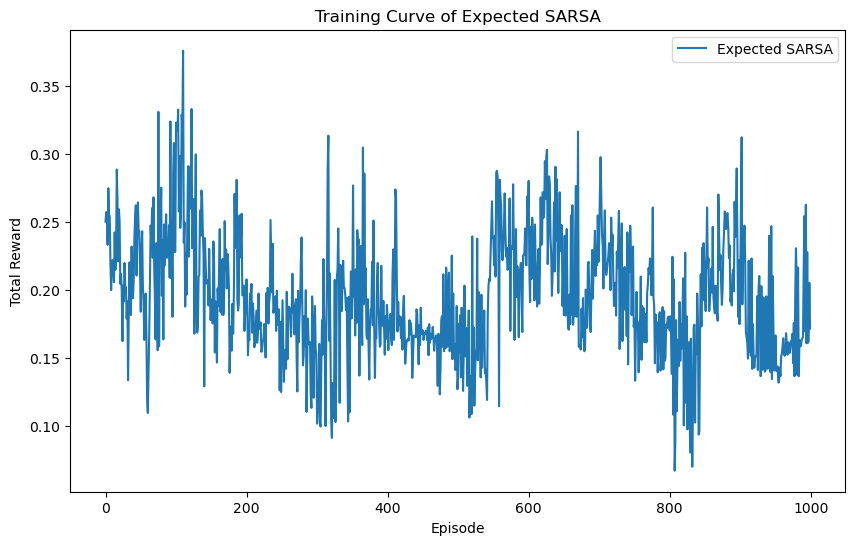

In [20]:
# device = torch.device("mps")
# E SARSA

e_sarsa_network = QNetwork(state_size, action_size)
e_sarsa_optimizer = optim.Adam(e_sarsa_network.parameters(), lr=1e-3)
e_sarsa_rewards = train_e_sarsa(e_sarsa_network, e_sarsa_optimizer, episodes=1000)

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(e_sarsa_rewards, label='Expected SARSA')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Curve of Expected SARSA')
plt.legend()
plt.show()

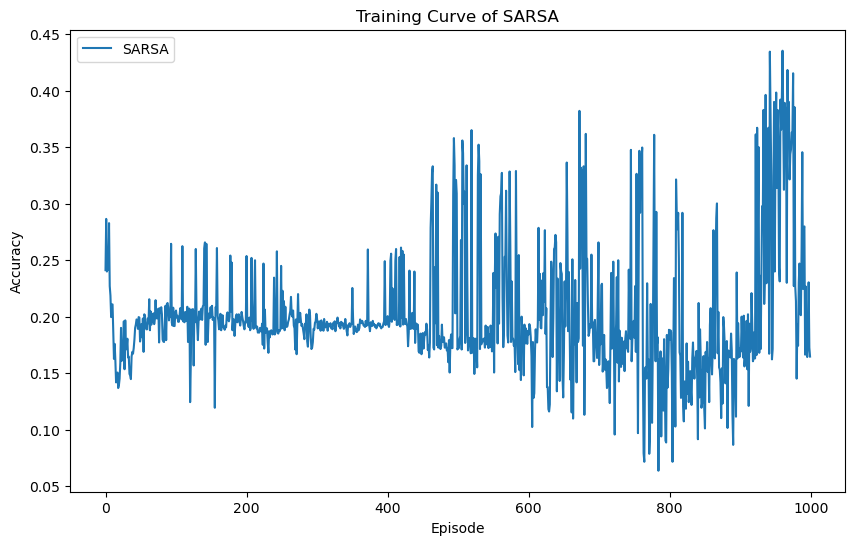

In [18]:
# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(e_sarsa_rewards, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.title('Training Curve of SARSA')
plt.legend()
plt.show()

In [50]:
max_value = None

In [82]:
for i in range(1000):
    from sklearn.model_selection import train_test_split
    
    train, test = train_test_split(dataset, test_size=0.2)
    
    # divide state and action
    train_state = train[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
    train_action = train[['next_action_id']]
    
    test_state = test[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
    test_action = test[['next_action_id']]
    
    categorical_cols = ['misconception_type', "convo_turn", 'done', 'listen_to_feedback', 'correct_solution',]
    continuous_cols = ['problem_progress', 'progress_delta']
    
    from sklearn.preprocessing import StandardScaler 
    
    scaler = StandardScaler()
    
    train_state_cat = pd.get_dummies(train_state[categorical_cols], drop_first=False).reset_index(drop=True)
    train_state_cont = pd.DataFrame(
        scaler.fit_transform(train_state[continuous_cols]),
        columns=continuous_cols
    ).reset_index(drop=True)
    
    train_state_processed = pd.concat([train_state_cat, train_state_cont], axis=1)
    train_state_tensor = torch.tensor(train_state_processed.values, dtype=torch.float32)
    train_action_tensor = torch.tensor(train_action.values, dtype=torch.long)
    
    scaler = StandardScaler()
    
    test_state_cat = pd.get_dummies(test_state[categorical_cols], drop_first=False).reset_index(drop=True)
    test_state_cont = pd.DataFrame(
        scaler.fit_transform(test_state[continuous_cols]),
        columns=continuous_cols
    ).reset_index(drop=True)
    
    test_state_processed = pd.concat([test_state_cat, test_state_cont], axis=1)
    test_state_tensor = torch.tensor(test_state_processed.values, dtype=torch.float32)
    test_action_tensor = torch.tensor(test_action.values, dtype=torch.long)
    
    
    class ImitationDataset(Dataset):
        def __init__(self, states, actions):
            self.states = states
            self.actions = actions
    
        def __len__(self):
            return len(self.states)
    
        def __getitem__(self, idx):
            return self.states[idx], self.actions[idx]
    
    train_dataset = ImitationDataset(train_state_tensor, train_action_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    test_dataset = ImitationDataset(test_state_tensor, test_action_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    correct = 0
    total = 0
    
    device = torch.device("mps")
    
    with torch.no_grad():
        for batch_states, batch_actions in test_dataloader:
    
            batch_states = batch_states.to(device)
            batch_actions = batch_actions.to(device)
            
            outputs = policy(batch_states)
    
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            
            total += batch_actions.size(0)
            correct += (predicted == batch_actions.squeeze()).sum().item()
    
        if max_value is None or max_value < (100 * correct / total):
            max_value = 100 * correct / total
    
    print(f'Accuracy of the network on the testing dataset: {100 * correct / total} %')


Accuracy of the network on the testing dataset: 71.50582362728785 %
Accuracy of the network on the testing dataset: 70.50748752079866 %
Accuracy of the network on the testing dataset: 71.630615640599 %
Accuracy of the network on the testing dataset: 71.54742096505824 %
Accuracy of the network on the testing dataset: 72.25457570715474 %
Accuracy of the network on the testing dataset: 72.71214642262895 %
Accuracy of the network on the testing dataset: 71.96339434276206 %
Accuracy of the network on the testing dataset: 71.92179700499167 %
Accuracy of the network on the testing dataset: 72.00499168053244 %
Accuracy of the network on the testing dataset: 72.87853577371048 %
Accuracy of the network on the testing dataset: 72.87853577371048 %
Accuracy of the network on the testing dataset: 72.50415973377704 %
Accuracy of the network on the testing dataset: 71.630615640599 %
Accuracy of the network on the testing dataset: 72.8369384359401 %
Accuracy of the network on the testing dataset: 71.79

In [81]:
correct = 0
total = 0

device = torch.device("mps")

with torch.no_grad():
    for batch_states, batch_actions in test_dataloader:

        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        
        outputs = policy(batch_states)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        
        total += batch_actions.size(0)
        correct += (predicted == batch_actions.squeeze()).sum().item()

    if max_value is None or max_value < (100 * correct / total):
        max_value = 100 * correct / total

print(f'Accuracy of the network on the testing dataset: {100 * correct / total} %')

Accuracy of the network on the testing dataset: 71.67221297836939 %


In [ ]:
73.66888519134775

In [83]:
max_value

75.08319467554077

In [4]:
# policy evaluation with Monte Carlo
def eval_policy(policy, eval_env, eval_episodes=10):
        avg_reward = 0.0
        for _ in range(eval_episodes):
            state, _ = eval_env.reset()
            done = False
            step = 0
            while not done:
                action = policy.select_action(np.array(state))
                state, reward, terminated, _, _ = eval_env.step(action)
                avg_reward += reward
                step += 1
                done = terminated
        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

In [5]:
class QNetwork(nn.Module):
    # FILL ME IN
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [6]:
def epsilon_greedy_policy(q_values, epsilon):
    # FILL ME IN
    max_a = torch.argmax(q_values).item()
    rand_a = np.random.choice(np.arange(2))

    a = np.random.choice([max_a, rand_a],
                          p=[1-epsilon,
                              epsilon])
    return a

In [7]:
# 5. SARSA Implementation

def sarsa_update(network, optimizer, state, action, reward, next_state, next_action, done, gamma=0.99):
    # The loss function for SARSA minimizes the squared difference between the target value y and the predicted Q-value Q_{\theta}(s, a):
    # Take gradient descent step to update the network parameters.
    # Return the loss.
    # FILL ME IN

    # Convert state to tensor and get Q-values
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = network(state_tensor)

    # Convert next_state to tensor and get Q-values
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
    with torch.no_grad():
        q_values_next = network(next_state_tensor)

    if done:
      y = reward
    else:
      y = reward + gamma * torch.squeeze(q_values_next)[next_action]
      y = y.detach()

    # update
    optimizer.zero_grad()

    loss = (y - torch.squeeze(q_values)[action]) ** 2

    loss.backward()
    optimizer.step()

    return loss


def train_sarsa(env, network, optimizer, episodes=500, gamma=0.99,
                epsilon_start=1.0, epsilon_end=0.01, decay=500):
    rewards_history = []
    steps_done = 0

    for ep in range(episodes):
        state,_ = env.reset()
        done = False

        # Choose initial action
        epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))
        q_values = network(torch.FloatTensor(state))
        action = epsilon_greedy_policy(q_values, epsilon)

        episode_reward = 0

        while not done:
            next_state, reward, done, info, _ = env.step(action)

            epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))

            q_values = network(torch.FloatTensor(next_state))
            next_action = epsilon_greedy_policy(q_values, epsilon)

            loss = sarsa_update(network, optimizer, state, action, reward,
                                next_state, next_action, done, gamma)

            state = next_state
            action = next_action
            episode_reward += reward
            steps_done += 1

        rewards_history.append(episode_reward)
        # print(episode_reward)
    return rewards_history


In [6]:
import sys
sys.path.append('../models/simulator_and_related_models/')
from env import simulator
env = simulator("/Users/liam/cos435_project/dataset/MathDial_map_back_4_actions.csv")

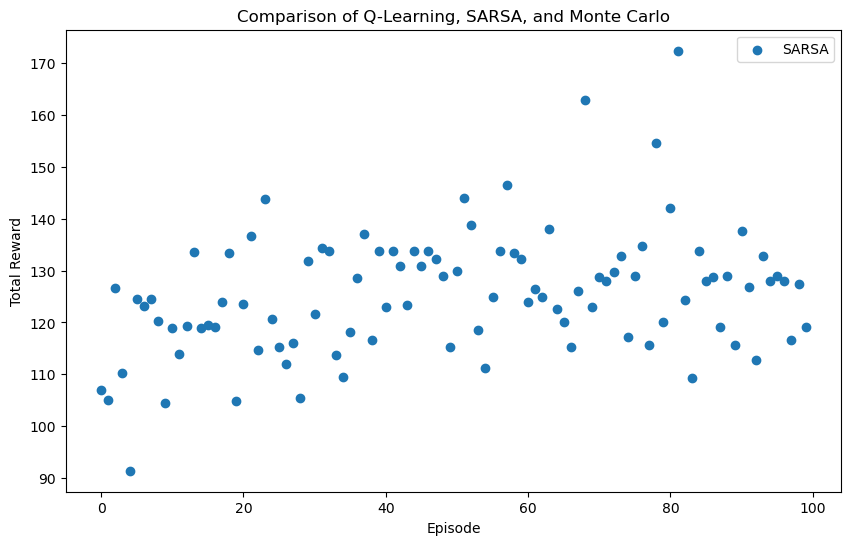

In [22]:
def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

# SARSA
sarsa_network = QNetwork(7, 4)
sarsa_optimizer = optim.Adam(sarsa_network.parameters(), lr=1e-3)
sarsa_rewards = train_sarsa(env, sarsa_network, sarsa_optimizer, episodes=10000)

sarsa_rewards_average = []
for i in range(0,10000,100):
    sarsa_rewards_average.append(np.mean(sarsa_rewards[i: i+100]))

# Plot learning curves
plt.figure(figsize=(10,6))
plt.scatter(x=np.arange(1000), y=sarsa_rewards_average, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Q-Learning, SARSA, and Monte Carlo')
plt.legend()
plt.show()

In [27]:
!pip install pickleshare

In [32]:
sarsa_rewards_average

[np.float64(107.0),
 np.float64(105.0),
 np.float64(126.6),
 np.float64(110.3),
 np.float64(91.4),
 np.float64(124.6),
 np.float64(123.1),
 np.float64(124.6),
 np.float64(120.2),
 np.float64(104.4),
 np.float64(118.9),
 np.float64(113.9),
 np.float64(119.3),
 np.float64(133.5),
 np.float64(118.9),
 np.float64(119.6),
 np.float64(119.2),
 np.float64(123.9),
 np.float64(133.4),
 np.float64(104.9),
 np.float64(123.6),
 np.float64(136.7),
 np.float64(114.7),
 np.float64(143.8),
 np.float64(120.6),
 np.float64(115.2),
 np.float64(111.9),
 np.float64(116.1),
 np.float64(105.4),
 np.float64(131.8),
 np.float64(121.6),
 np.float64(134.4),
 np.float64(133.8),
 np.float64(113.8),
 np.float64(109.4),
 np.float64(118.1),
 np.float64(128.5),
 np.float64(137.1),
 np.float64(116.7),
 np.float64(133.8),
 np.float64(123.0),
 np.float64(133.8),
 np.float64(130.8),
 np.float64(123.4),
 np.float64(133.8),
 np.float64(130.9),
 np.float64(133.8),
 np.float64(132.2),
 np.float64(128.9),
 np.float64(115.2),
 

In [35]:
import pickle
dbfile = open('sarsa_rewards_average.pkl', 'wb')
pickle.dump(sarsa_rewards_average, dbfile)
dbfile.close()

Stored 'sarsa_rewards_average' (list)


/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/sarsa_rewards_average requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


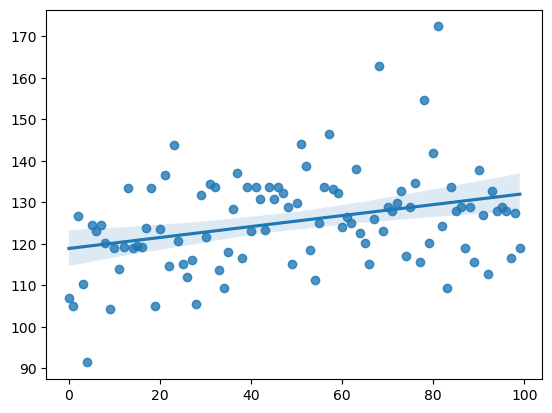

In [26]:
import numpy as np
import seaborn as sns

sns.regplot(x=np.arange(100), y=sarsa_rewards_average)

%store sarsa_rewards_average

In [14]:
sarsa_rewards_average

[np.float64(105.2),
 np.float64(109.0),
 np.float64(131.6),
 np.float64(110.3),
 np.float64(108.3),
 np.float64(123.2),
 np.float64(111.4),
 np.float64(118.7),
 np.float64(123.3),
 np.float64(132.4),
 np.float64(126.1),
 np.float64(106.6),
 np.float64(116.8),
 np.float64(117.0),
 np.float64(125.7),
 np.float64(102.1),
 np.float64(125.4),
 np.float64(114.3),
 np.float64(124.4),
 np.float64(97.2),
 np.float64(129.8),
 np.float64(111.4),
 np.float64(128.0),
 np.float64(107.3),
 np.float64(127.9),
 np.float64(128.8),
 np.float64(98.7),
 np.float64(140.1),
 np.float64(123.4),
 np.float64(106.9),
 np.float64(122.0),
 np.float64(119.3),
 np.float64(132.6),
 np.float64(130.4),
 np.float64(126.0),
 np.float64(131.5),
 np.float64(126.9),
 np.float64(102.0),
 np.float64(113.7),
 np.float64(130.4),
 np.float64(118.1),
 np.float64(122.6),
 np.float64(118.6),
 np.float64(139.5),
 np.float64(122.5),
 np.float64(140.6),
 np.float64(118.1),
 np.float64(124.0),
 np.float64(119.1),
 np.float64(122.0),
 n

In [36]:
policy = torch.jit.load("../models/BC_5000epochs_6layers_1024neurons.pt")
policy.eval()
policy = policy.to(torch.device("mps"))

import sys
sys.path.append('../models/simulator_and_related_models/')
from env import simulator

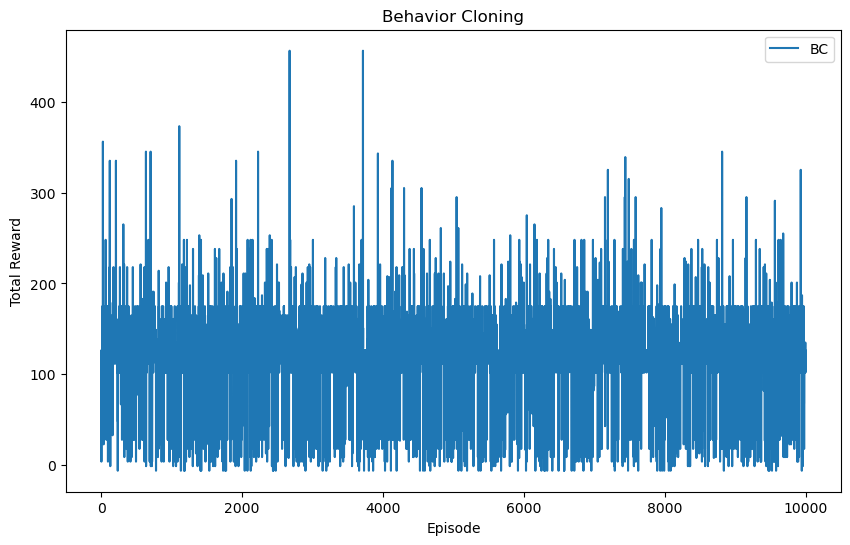

In [37]:
# [self.misconception_type, self.convo_turn, self.done, 
#                 int(self.listen_to_feedback),int(self.problem_progress),
#                 int(self.progress_delta), int(self.correct_solution)]

def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

def evaluate_policy(policy, env, seed=42):
    env_test = env
    state, _ = env_test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(torch.device("mps"))
        action = policy(state)
        _, action = torch.max(action, 1)
        next_state, reward, done, _, _ = env_test.step(action)
        state = next_state
        total_reward += reward
    return total_reward


BC_rewards = [evaluate_policy(policy, env) for i in range(10000)]
# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(BC_rewards, label='BC')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Behavior Cloning')
plt.legend()
plt.show()

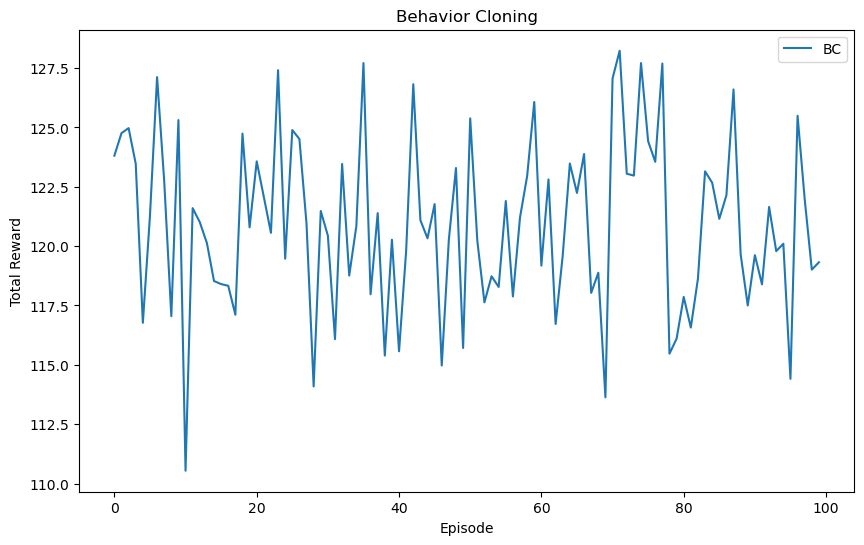

In [39]:
rewards_average = []
for i in range(0,10000,100):
    rewards_average.append(np.mean(BC_rewards[i: i+100]))

plt.figure(figsize=(10,6))
plt.plot(rewards_average, label='BC')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Behavior Cloning')
plt.legend()
plt.show()

import pickle
dbfile = open('BC_rewards_average.pkl', 'wb')
pickle.dump(rewards_average, dbfile)
dbfile.close()